# Start Display vs Start Timing Feature Engineering

Target files:
- data/previews/2026/01/15.csv
- data/results/2026/01/15.csv

Goal: Create features that capture the relationship between "スタート展示" and "スタートタイミング" and explore their correlation with finish position.


Notes:
- Smaller finish position is better.
- Negative start timing indicates an earlier start.
- Rows with missing start values are excluded from feature calculations.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

cwd = Path.cwd()
repo_root = cwd if (cwd / 'data').exists() else cwd.parent.parent

year = '2026'
month = '01'
day = '15'

preview_path = repo_root / 'data' / 'previews' / year / month / f'{day}.csv'
result_path = repo_root / 'data' / 'results' / year / month / f'{day}.csv'

preview_path.exists(), result_path.exists()


(True, True)

In [2]:
preview = pd.read_csv(preview_path)
results = pd.read_csv(result_path)

preview.shape, results.shape


((105, 53), (166, 100))

In [3]:
race_cols = ['レースコード', 'レース日', 'レース場', 'レース回']
boat_features = ['艇番', 'コース', 'スタート展示']

boat_frames = []
for b in range(1, 7):
    rename = {f'艇{b}_{col}': col for col in boat_features}
    cols = race_cols + list(rename.keys())
    tmp = preview[cols].rename(columns=rename)
    tmp['艇'] = b
    boat_frames.append(tmp)

preview_long = pd.concat(boat_frames, ignore_index=True)
preview_long.head()


,レースコード,レース日,レース場,レース回,艇番,コース,スタート展示,艇
0,202601150101,2026-01-15,1,01R,1,1.0,0.06,1
1,202601150102,2026-01-15,1,02R,1,1.0,0.09,1
2,202601150103,2026-01-15,1,03R,1,1.0,-0.02,1
3,202601150104,2026-01-15,1,04R,1,1.0,0.05,1
4,202601150105,2026-01-15,1,05R,1,2.0,0.13,1


In [4]:
result_frames = []
for order in range(1, 7):
    boat_col = f'{order}着_艇番'
    start_col = f'{order}着_スタートタイミング'
    if boat_col in results.columns and start_col in results.columns:
        tmp = results[['レースコード', boat_col, start_col]].copy()
        tmp = tmp.rename(columns={boat_col: '艇番', start_col: 'スタートタイミング'})
        tmp['着順'] = order
        result_frames.append(tmp)

result_long = pd.concat(result_frames, ignore_index=True)
result_long = result_long.dropna(subset=['艇番'])
result_long.head()


,レースコード,艇番,スタートタイミング,着順
0,202601152401,4.0,0.24,1
1,202601152402,6.0,0.06,1
2,202601152403,2.0,0.19,1
3,202601152404,1.0,0.13,1
4,202601152405,3.0,0.17,1


In [5]:
merged = preview_long.merge(result_long, on=['レースコード', '艇番'], how='left')
merged[['レースコード', '艇番', 'スタート展示', 'スタートタイミング', '着順']].head()


,レースコード,艇番,スタート展示,スタートタイミング,着順
0,202601150101,1,0.06,0.27,1.0
1,202601150102,1,0.09,0.23,1.0
2,202601150103,1,-0.02,0.23,4.0
3,202601150104,1,0.05,0.11,1.0
4,202601150105,1,0.13,0.20,6.0


In [6]:
merged['start_display'] = pd.to_numeric(merged['スタート展示'], errors='coerce')
merged['start_timing'] = pd.to_numeric(merged['スタートタイミング'], errors='coerce')

merged = merged.dropna(subset=['start_display', 'start_timing', '着順']).copy()

race_group = merged.groupby('レースコード')

merged['start_delta'] = merged['start_timing'] - merged['start_display']
merged['start_delta_abs'] = merged['start_delta'].abs()

merged['start_display_rank'] = race_group['start_display'].rank(method='average', ascending=True)
merged['start_timing_rank'] = race_group['start_timing'].rank(method='average', ascending=True)
merged['start_rank_diff'] = merged['start_timing_rank'] - merged['start_display_rank']

merged['start_display_centered'] = merged['start_display'] - race_group['start_display'].transform('mean')
merged['start_timing_centered'] = merged['start_timing'] - race_group['start_timing'].transform('mean')

def zscore(series):
    std = series.std(ddof=0)
    if std == 0 or np.isnan(std):
        return pd.Series([np.nan] * len(series), index=series.index)
    return (series - series.mean()) / std

merged['start_display_z'] = race_group['start_display'].transform(zscore)
merged['start_timing_z'] = race_group['start_timing'].transform(zscore)

merged[['start_display', 'start_timing', 'start_delta', 'start_delta_abs', 'start_rank_diff']].head()


,start_display,start_timing,start_delta,start_delta_abs,start_rank_diff
0,0.06,0.27,0.21,0.21,1.0
1,0.09,0.23,0.14,0.14,-4.0
2,-0.02,0.23,0.25,0.25,0.5
3,0.05,0.11,0.06,0.06,-3.0
4,0.13,0.20,0.07,0.07,-2.0


In [7]:
feature_cols = [
    'start_display', 'start_timing', 'start_delta', 'start_delta_abs',
    'start_display_rank', 'start_timing_rank', 'start_rank_diff',
    'start_display_centered', 'start_timing_centered',
    'start_display_z', 'start_timing_z',
]

numeric = merged[feature_cols + ['着順']].apply(pd.to_numeric, errors='coerce')
corr = numeric.corr(method='spearman')['着順'].drop('着順')

corr.sort_values(key=lambda s: s.abs(), ascending=False)


start_timing_centered     0.405213
start_timing_z            0.401298
start_timing_rank         0.389072
start_timing              0.254963
start_rank_diff           0.251180
start_delta_abs           0.101137
start_delta               0.091191
start_display_centered    0.072159
start_display_z           0.070785
start_display_rank        0.068318
start_display             0.058817
Name: 着順, dtype: float64

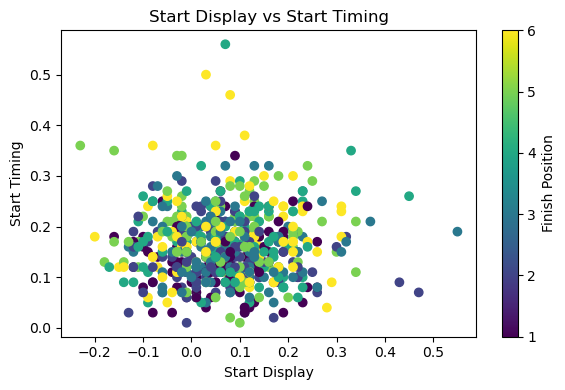

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(merged['start_display'], merged['start_timing'], c=merged['着順'], cmap='viridis')
plt.colorbar(label='Finish Position')
plt.title('Start Display vs Start Timing')
plt.xlabel('Start Display')
plt.ylabel('Start Timing')
plt.tight_layout()


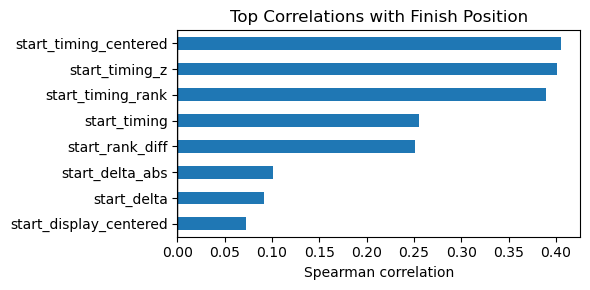

In [9]:
top = corr.dropna().sort_values(key=lambda s: s.abs(), ascending=False).head(8)
ax = top.sort_values().plot(kind='barh', figsize=(6, 3), title='Top Correlations with Finish Position')
ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel('Spearman correlation')
plt.tight_layout()


Next ideas:
- Compare start timing with race-day wind (merge preview weather features).
- Add interaction terms like start_display_rank * course.
- Aggregate historical start timing per racer if you expand beyond one day.
